<small>Este material foi produzido para o *Curso Básico de Google Earth Engine no Python (usando o Google Colab )*. https://www.github.com/andrebelem/Curso_GEE. Versão 1.0 | © 2024 Andre Belem
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andrebelem/Curso_GEE/blob/main/Modulo02_Visualizacao_de_Dados_no_geemap.ipynb). Se você tem algum tipo de dúvida ou quiser fazer um comentário, sugestão ou colaborar com este notebook... [![Mail Me](https://img.shields.io/badge/Envie_um-Email-blue)](mailto:andrebelem@id.uff.br)</small>

## Lembre-se ! Primeiro, comece autenticando.

Se você ainda tem dúvidas sobre este processo, veja o [`Módulo_1_Introdução_ao_geemap.ipynb`](https://github.com/andrebelem/Curso_GEE/blob/main/Modulo01_Introducao_ao_geemap.ipynb).

In [1]:
import ee
import geemap
ee.Authenticate()

In [2]:
# Aqui vocẽ deve trocar o projeto pelo "SEU-PROJECT-ID"
ee.Initialize(project='ee-andrebelem')

## Visualizando dados do Earth Engine

O Google Earth Engine é uma plataforma poderosa para a análise e visualização de dados geoespaciais. Uma das ferramentas mais úteis para explorar esses dados é a <u>ferramenta de inspeção</u> (*inspector*). Esta ferramenta permite que os usuários examinem os valores de pixels em imagens raster e as propriedades das features em conjuntos de dados vetoriais. Para fazer isso, utilize a função `add_inspector()` e com a ferramenta ativada, clique em diferentes áreas do mapa para visualizar os valores dos pixels e as propriedades das features.

Por exemplo, vamos examinar a cidade de Sorriso, no MT:


In [3]:
# Carregando a FeatureCollection
dataset = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq("ADM0_NAME", "Brazil"))   #<--- note que mudei para o nível 2

# uma maneira de listar o que precisamos é usando a função `ee.Reducer.toList()`
import pandas as pd

country = dataset.reduceColumns(ee.Reducer.toList(), ['ADM0_NAME']).get('list').getInfo()
adm1 = dataset.reduceColumns(ee.Reducer.toList(), ['ADM1_NAME']).get('list').getInfo()
adm2 = dataset.reduceColumns(ee.Reducer.toList(), ['ADM2_NAME']).get('list').getInfo()


data = pd.DataFrame({'cidade': adm2, 'estado': adm1, 'país': country})

# Usando query para encontrar a cidade de Sorriso no estado de Mato Grosso
cidade = data.query("cidade == 'Sorriso' and estado == 'Mato Grosso'")

...agora criando um mapa da cidade de Sorriso.

In [4]:
# Criando um mapa com geemap
map = geemap.Map()

area_de_interesse = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq("ADM2_NAME", "Sorriso"))

# escolhendo as imagens e tirando a mediana
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterDate("2023-01-01", "2024-01-01")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5)) #<--- note que só selecionamos imagens com <5% de nuvens
)

# Calculando a mediana e recortando pela área da cidade de Sorriso no MT
image = collection.median().clip(area_de_interesse) #<--- veja que estou dando um clip no objeto

vis = {
    "min": 0.0,
    "max": 3000,
    "bands": ["B4", "B3", "B2"]
}
map.add_layer(image, vis, "Sentinel-2")
map.add_layer(area_de_interesse, {}, "Sorriso")
map.center_object(area_de_interesse, 10) #<--- note que vocẽ terá que ajustar o zoom de acordo com sua área
map.add("inspector")
map

Map(center=[-12.735635928624818, -55.68104822644536], controls=(WidgetControl(options=['position', 'transparen…

No mapa acima, clique sobre qualquer feição que vocẽ queira, e verá que vai abrir uma janela com valores de cada banda de *image* e também das outras layers ativas da imagem. Isso é especialmente útil quando queremos construir parâmetros de visibilidade de cores com base em diferentes bandas. Vocẽ pode ambém explorar o perfil espectral dos pixels usando a *plotting tool*. Veja o exemplo abaixo:

In [5]:
map = geemap.Map(center=[-12.7743, -52.3553], zoom=10)

landsat7 = ee.Image("LANDSAT/LE7_TOA_5YEAR/1999_2003").select(
    ["B1", "B2", "B3", "B4", "B5", "B7"]
)

landsat_vis = {"bands": ["B4", "B3", "B2"], "gamma": 1.4}
map.add_layer(landsat7, landsat_vis, "Landsat")

hyperion = ee.ImageCollection("EO1/HYPERION").filter(
    ee.Filter.date("2016-01-01", "2017-03-01")
)

hyperion_vis = {
    "min": 1000.0,
    "max": 14000.0,
    "gamma": 2.5,
}
map.add_layer(hyperion, hyperion_vis, "Hyperion")
map.add_plot_gui()
map

# depois que aparecer o mapa, clique sobre a faixa. Sempre "dê um tempo" até carregar o dado.

Map(center=[-12.7743, -52.3553], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [6]:
# posso ainda fazer overlays
map.set_plot_options(add_marker_cluster=True, overlay=True)

In [7]:
map.set_plot_options(add_marker_cluster=True, plot_type="bar")

### Legendas, barra de cores, e etiquetas (*labels*)

No Google Earth Engine, a visualização eficaz de dados geoespaciais é essencial para a interpretação e análise. O uso de legendas, barras de cores e etiquetas (labels) facilita a compreensão dos mapas ao fornecer contexto e informações adicionais sobre os dados visualizados. A biblioteca `geemap` simplifica a criação dessas visualizações enriquecidas em Python. Abaixo, vamos explorar como adicionar legendas, barras de cores e etiquetas a um mapa usando `geemap`.

In [8]:
# estas são as opções que temos de legendas no geemap
from geemap.legends import builtin_legends
for legend in builtin_legends:
    print(legend)

NLCD
ESA_WorldCover
ESRI_LandCover
ESRI_LandCover_TS
Dynamic_World
NWI
MODIS/051/MCD12Q1
MODIS/006/MCD12Q1
GLOBCOVER
JAXA/PALSAR
Oxford
AAFC/ACI
COPERNICUS/CORINE/V20/100m
COPERNICUS/Landcover/100m/Proba-V/Global
USDA/NASS/CDL
ALOS_landforms


In [9]:
map = geemap.Map(center=[-21.14, -42.42], zoom=8)
map.add_basemap("Esri.WorldImagery")
map.add_basemap("ESA Worldcover 2020")
map.add_legend(
    title="ESRI World Cover",
    builtin_legend="ESA_WorldCover",
    max_width="100px",
    height="455px",
)
map

Map(center=[-21.14, -42.42], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

O mais interessante aqui é que podemos usar *custom legends* com nossas cores próprias. Por exemplo, olhando no catálogo, podemos ver que o produto [Copernicus Global Land Cover Layers](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global) contém uma classificação com base em imagens de satélite. Para criramos uma legenda *custom*, basta criar um `dict`:

In [10]:
legenda_dict = {
    "0 Desconhecido": "#282828",
    "20 Arbustos": "#ffbb22",
    "30 Vegetação herbácea": "#ffff4c",
    "40 Vegetação cultivada / agricultura": "#f096ff",
    "50 Urbano / construído": "#fa0000",
    "60 Solo exposto / vegetação esparsa": "#b4b4b4",
    "70 Neve e gelo": "#f0f0f0",
    "80 Corpos d'água permanentes": "#0032c8",
    "90 Pântano herbáceo": "#0096a0",
    "100 Musgo e líquen": "#fae6a0",
    "111 Floresta fechada, folha perene aciculifoliada": "#58481f",
    "112 Floresta fechada, folha perene latifoliada": "#009900",
    "113 Floresta fechada, folha caduca aciculifoliada": "#70663e",
    "114 Floresta fechada, folha caduca latifoliada": "#00cc00",
    "115 Floresta fechada, mista": "#4e751f",
    "116 Floresta fechada, sem correspondência": "#007800",
    "121 Floresta aberta, folha perene aciculifoliada": "#666000",
    "122 Floresta aberta, folha perene latifoliada": "#8db400",
    "123 Floresta aberta, folha caduca aciculifoliada": "#8d7400",
    "124 Floresta aberta, folha caduca latifoliada": "#a0dc00",
    "125 Floresta aberta, mista": "#929900",
    "126 Floresta aberta, sem correspondência": "#648c00",
    "200 Oceanos, mares": "#000080"
}


In [11]:
map = geemap.Map(center=[-22.85, -43.16], zoom=10)
map.add_basemap("Esri.WorldImagery")


# Carregando a coleção de imagens e aplicando o filtro
landcover = ee.Image('COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019')\
    .select('discrete_classification')

map.add_layer(landcover, {}, "Copernicus Global Land Cover")
map.add_legend(title="Land Cover", legend_dict=legenda_dict, height="455px")
map

Map(center=[-22.85, -43.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

#### Barra de Cores

Ela pode ser criada tanto na horizontal quanto na vertical.

In [12]:
# Note que a construção aqui permite eu criar uma máscara para altura = 0 !!!
map = geemap.Map(center=[-22.85, -43.16], zoom=10)

dem = ee.Image("USGS/SRTMGL1_003")

# Criando uma máscara para os valores de elevação igual a 0
zero_mask = dem.updateMask(dem.eq(0)).visualize(**{
    "palette": ["000000"],  # Preto
    "min": 0,
    "max": 1,
})

# Definindo os parâmetros de visualização para os valores diferentes de 0
vis_params = {
    "min": 0,
    "max": 1000,
    "palette": ["006633", "E5FFCC", "662A00", "D8D8D8", "F5F5F5"],
}

# Visualizando a imagem DEM sem os valores igual a 0
dem_vis = dem.updateMask(dem.neq(0)).visualize(**vis_params)

# Combinando as camadas
combined = ee.ImageCollection([zero_mask, dem_vis]).mosaic()

# Adicionando a camada combinada ao mapa
map.addLayer(combined, {}, "SRTM DEM com Valor 0 em Preto")
map.add_colorbar(vis_params, label="Elevation (m)", layer_name="SRTM DEM")

# Exibindo o mapa
map

Map(center=[-22.85, -43.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [13]:
# note que a barra de cores irá mudar de posição...
map.add_colorbar(
    vis_params,
    label="Elevation (m)",
    layer_name="SRTM DEM",
    orientation="vertical",
    max_width="100px",
)

In [14]:
# ou ficar transparente
map.add_colorbar(
    vis_params,
    label="Elevation (m)",
    layer_name="SRTM DEM",
    orientation="vertical",
    max_width="100px",
    transparent_bg=True,
)

### Mapa de Painel Dividido e Mapas Vinculados

É possível criar um mapa dividido com mapas base. Os mapas de painel dividido são uma poderosa ferramenta de visualização que permite comparar dois mapas lado a lado. Essa funcionalidade é especialmente útil para comparar diferentes conjuntos de dados geoespaciais ou visualizar mudanças ao longo do tempo. Por exemplo, você pode comparar imagens de satélite de diferentes anos, visualizar a diferença entre mapas topográficos e imagens aéreas, ou analisar mudanças na cobertura do solo.

In [15]:
map = geemap.Map(center=[-22.85, -43.16], zoom=8)
map.split_map(left_layer="Esri.WorldTopoMap", right_layer="OpenTopoMap")
map

Map(center=[-22.85, -43.16], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

Agora, vamos criar com dados de verdade ! Vou selecionar dois conjuntos de imagens, a primeira do Sentinel-2 e a outra do Copernicus Land Cover.

In [16]:
map = geemap.Map(center=[-22.85, -43.16], zoom=8, height=600)

# escolhendo as imagens e tirando a mediana
sentinel_collection = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterDate("2023-01-01", "2024-01-01")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5)) #<--- note que só selecionamos imagens com <5% de nuvens
)

# Calculando a mediana
sentinel = sentinel_collection.median()
vis = {
    "min": 0.0,
    "max": 3000,
    "bands": ["B4", "B3", "B2"]
}

landcover = ee.Image('COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019')\
              .select('discrete_classification')

# agora montando os painéis

left_layer = geemap.ee_tile_layer(sentinel, vis, "Sentinel-2")
right_layer = geemap.ee_tile_layer(landcover, {}, "Copernicus 2019 land cover")

map.split_map(left_layer, right_layer, left_label="Sentinel-2", right_label="Land Cover")
# Adicionando a legenda ao mapa
map.add_legend(title="Land Cover Legend", legend_dict=legenda_dict)
map

Map(center=[-22.85, -43.16], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

### *Timeseries inspector* e *Time Slider*

Estas duas funcionalidades são muito úteis porque elas permiter trabalhar com variações *no tempo*. Porém, é importante que você construa um plano do que quer mostrar, para não ficar perdido nos códigos.

In [17]:
# lembrando, precisamos de nossa legenda. Ela foi obtida do site do produto MODIS/061/MCD12Q1
legenda = {
    "1 Florestas de Coníferas Sempre-verdes": "05450a",
    "2 Florestas de Folhas Largas Sempre-verdes": "086a10",
    "3 Florestas de Coníferas Decíduas": "54a708",
    "4 Florestas de Folhas Largas Decíduas": "78d203",
    "5 Florestas Mistas": "009900",
    "6 Arbustais Fechados": "c6b044",
    "7 Arbustais Abertos": "dcd159",
    "8 Savanas Arborizadas": "dade48",
    "9 Savanas": "fbff13",
    "10 Pastagens": "b6ff05",
    "11 Áreas Úmidas Permanentes": "27ff87",
    "12 Terras Agrícolas": "c24f44",
    "13 Áreas Urbanas e Construídas": "a5a5a5",
    "14 Mosaicos de Agricultura/Vegetação Natural": "ff6d4c",
    "15 Neve e Gelo Permanentes": "69fff8",
    "16 Terras Áridas": "f9ffa4",
    "17 Corpos d'Água": "1c0dff"
}

In [18]:
map = geemap.Map(center=[-22.85, -43.16], zoom=8)
collection = ee.ImageCollection("MODIS/061/MCD12Q1").select("LC_Type1")
vis_params = {"bands": ["LC_Type1"],
              "min": 1.0,
              "max": 17.0,
              "palette": [
                  '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
                  'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
                  '69fff8', 'f9ffa4', '1c0dff'
                  ]}
years = collection.aggregate_array("system:index").getInfo()
years #<--- note que você terá os anos aqui, agregados pelo index da Image Collection

['2001_01_01',
 '2002_01_01',
 '2003_01_01',
 '2004_01_01',
 '2005_01_01',
 '2006_01_01',
 '2007_01_01',
 '2008_01_01',
 '2009_01_01',
 '2010_01_01',
 '2011_01_01',
 '2012_01_01',
 '2013_01_01',
 '2014_01_01',
 '2015_01_01',
 '2016_01_01',
 '2017_01_01',
 '2018_01_01',
 '2019_01_01',
 '2020_01_01',
 '2021_01_01',
 '2022_01_01']

Agora vamos criar um *inspetor de séries temporais* para o produto MODIS. Note que o `ipyleaflet` tem um bug com o `SplitControl`. Você não pode mover o mapa, o que deve ser resolvido em uma futura versão do `ipyleaflet`. Então, para usar essa função, é interessante que você já tenha na sua janela, o `center` e o `zoom` desejado.

In [19]:
map.ts_inspector(
    left_ts=collection,
    right_ts=collection,
    left_names=years,
    right_names=years,
    left_vis=vis_params,
    right_vis=vis_params,
    width="80px",
)
# Adicionando a legenda ao mapa
map.add_legend(title="Land Cover Legend", legend_dict=legenda)
map

Map(center=[-22.85, -43.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Dropdown(l…

O recurso de *Time Slider* é bastante interessante quando você tem uma coleção de imagens e quer examinar mudanças temporais. Por exemplo, vamos olhar o produto `MODIS/MCD43A4_006_NDVI` em Fevereiro de 2023. Note que você tem que "dar tempo" para as imagens serem carregadas.

In [20]:
map= geemap.Map(center=[-22.85, -43.16], zoom=10)

collection = (
    ee.ImageCollection("MODIS/MCD43A4_006_NDVI")
    .filter(ee.Filter.date("2023-02-01", "2023-03-01"))
    .select("NDVI")
)
vis_params = {
    "min": 0.0,
    "max": 1.0,
    "palette": "ndvi",
}

map.add_time_slider(collection, vis_params, time_interval=2)
map

Map(center=[-22.85, -43.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Algo que é bastante útil, é examinarmos os valores dentro de uma determinada região. Por exemplo, vamos examinar os valores de NDVI deste produto MODIS em um retângulo que engloba a Floresta da Tijuca. Note que os valores aqui de NDVI (Normalized Difference Vegetation Index) vão de -1 à 1 e a operação é feita apenas sobre a última imagem.

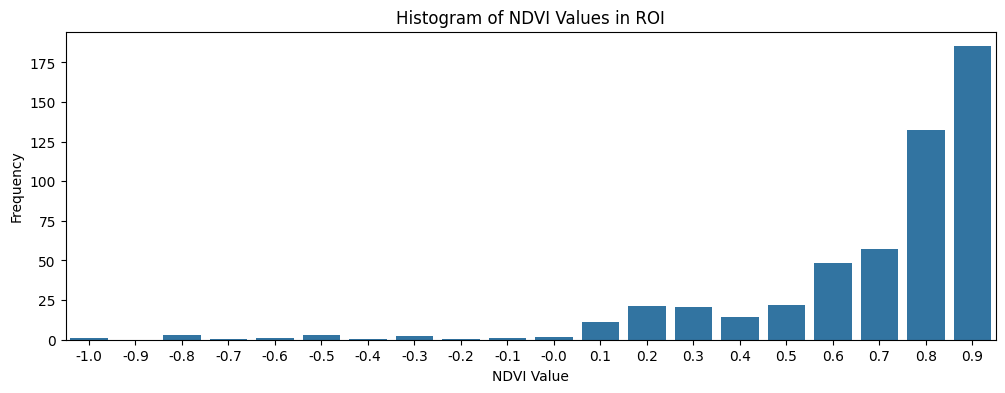

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Definindo uma região de interesse (ROI)
roi = ee.Geometry.Rectangle([-43.35, -23.00, -43.19, -22.89])

# Obtendo a última imagem da coleção para análise
image = collection.first()

# Calculando o histograma dos valores de LC_Type1 na ROI
histogram = image.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=roi,
    scale=500,
    maxPixels=1e9
).get('NDVI').getInfo()

# Convertendo o histograma em um DataFrame
hist_df = pd.DataFrame(list(histogram.items()), columns=['NDVI', 'Frequency'])

# Convertendo os valores de NDVI para float
hist_df['NDVI'] = hist_df['NDVI'].astype(float)

# Arredondando os valores de NDVI para 1 casa decimal
hist_df['NDVI'] = hist_df['NDVI'].round(1)

# Agrupando os valores por NDVI arredondado
hist_df = hist_df.groupby('NDVI', as_index=False).sum()

plt.figure(figsize=(12, 4))
# Plotando o histograma com Seaborn
sns.barplot(x='NDVI', y='Frequency', data=hist_df)
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.title('Histogram of NDVI Values in ROI')
plt.show()

Você quer plotar uma "Previsão do Tempo" ? Sim ! é possível. O produto `NOAA/GFS0P25` apresenta o resultado do (GFS) Global Forecast System 384-Hour Predicted Atmosphere Data. Porém note que o tempo de latência é de normalmente 24 horas.


In [22]:
map = geemap.Map(center=[-22.85, -43.16], zoom=7)

collection = (
    ee.ImageCollection("NOAA/GFS0P25")
    .filterDate("2024-07-28", "2024-07-29")
    .limit(24)
    .select("temperature_2m_above_ground")
)

vis_params = {
    "min": 15.,
    "max": 25.,
    "palette": ["blue", "purple", "cyan", "green", "yellow", "red"],
}

labels = [str(n).zfill(2) + ":00" for n in range(0, 24)]
map.add_time_slider(collection, vis_params, labels=labels, time_interval=1, opacity=0.8)
map.add_colorbar(vis_params, label="2m Temperature (°C)", layer_name="temp_label")
map

Map(center=[-22.85, -43.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Ou então, vamos plotar um *time slider* com imagens do Sentinel, para monitorar o Parque Estadual da Serra da Tirica.

In [23]:
map = geemap.Map(center=[-22.93, -43.01], zoom=12)

collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2024-04-01", "2024-07-29")
    .filterBounds(ee.Geometry.Point([-43.01, -22.93]))
    .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 10)
)

vis_params = {"min": 0, "max": 4000, "bands": ["B8", "B4", "B3"]}

map.add_time_slider(collection, vis_params)
map

Map(center=[-22.93, -43.01], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

### Exercício proposto 2 - Criando mapas de cobertura do solo com uma legenda

Crie um mapa dividido para visualizar as mudanças na cobertura do solo em um estado do Brasil (ou uma área) entre 2001 e 2019. Adicione uma legenda ao mapa. Procure os ativos (assets) relevantes para esse desafio.

In [24]:
# Escreva seu código aqui ou crie um notebook separado